In [114]:
import os
os.chdir('/Users/jjaniak/Documents/studia/projekt/gradient')

import geopandas as gpd
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np

from shapely.wkt import loads

from esda.moran import Moran_Local
import libpysal

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from src.embedders.osm_data_embedder import OSMDataEmbedder
from srai.regionalizers import geocode_to_region_gdf
from srai.embedders import CountEmbedder
from srai.regionalizers import H3Regionalizer
from srai.loaders.osm_loaders.filters import OsmTagsFilter

from IPython.display import display

pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [115]:
city_name = "Pozna\u0144"
nominatim_city_name = "Pozna\u0144, Poland"
year = 2022

In [116]:
# Parameters
city_name = "Pozna\u0144"
nominatim_city_name = "Pozna\u0144, Poland"
year = 2022


## Functions

In [117]:
query: OsmTagsFilter = {"highway": True, "railway": True, "route": True}


def create_hex_gds(h3_resolution, city_name=city_name):
    data_embedder = OSMDataEmbedder(
        area=geocode_to_region_gdf(nominatim_city_name),
        embedder=CountEmbedder(),
        regionalizer=H3Regionalizer(resolution=h3_resolution),
        query=query,
    )

    filename = f"data/baseline-datasets/in/{city_name}-hex-res-{h3_resolution}-and-features-gdf.shp"

    if not os.path.exists(filename):
        hex_and_features_gdf = data_embedder.make_embeddings()  # type: ignore
        hex_and_features_gdf.to_file(
            filename,
            index=True,
        )
    else:
        hex_and_features_gdf = gpd.read_file(filename)
        hex_and_features_gdf.set_index("region_id", inplace=True)

    return hex_and_features_gdf


def get_accidents_gdf(h3_resolution, city_name=city_name, year=year):
    filename = f"data/accidents_in_hex/{city_name}_accidents_{year}_res{h3_resolution}.csv"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    else:
        accidents_df = pd.read_csv(filename)
        accidents_df['geometry'] = accidents_df['geometry'].apply(loads)
        accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry='geometry', crs="EPSG:4326")
        return accidents_gdf
    
def merge_gdf(accidents_gdf, hex_and_features_gdf):
    merged_gdf = gpd.sjoin(left_df=accidents_gdf, right_df=hex_and_features_gdf, how='inner', op='intersects')
    merged_gdf = merged_gdf.drop(columns='index_right')
    merged_gdf.rename(columns={'count': 'num_accidents'}, inplace=True)
    merged_gdf['num_accidents'] = merged_gdf['num_accidents'].astype(int)

    return merged_gdf

In [118]:
def local_moran(df, column):
    w = libpysal.weights.Queen.from_dataframe(df)
    y = df[column].values
    moran_loc = Moran_Local(y, w)
    return moran_loc.Is, moran_loc.p_sim, moran_loc.q

In [119]:
def correlation_analysis(merged_gdf):
    all_features = merged_gdf.drop(columns=['geometry', 'region_id', 'num_accidents', 'binary_accidents']).columns.to_list()
    
    correlation_matrix = merged_gdf[all_features + ['binary_accidents']].corr()
    correlation_values = correlation_matrix['binary_accidents']

    correlation_metrics = correlation_values.drop('binary_accidents').describe()

    # Calculate the interquartile range (IQR)
    Q1 = correlation_values.drop('binary_accidents').quantile(0.25)
    Q3 = correlation_values.drop('binary_accidents').quantile(0.75)
    IQR = Q3 - Q1

    # Filter features based on IQR
    best_features = correlation_values[(correlation_values < (Q1 - 0.5 * IQR)) | (correlation_values > (Q3 + 0.5 * IQR))].index.to_list()

    best_features.remove('binary_accidents')
    correlation_matrix_best_features = merged_gdf[best_features + ['binary_accidents']].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix_best_features, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap (best features)')
    plt.show()

    return best_features, correlation_metrics

In [120]:
def shap_analysis(h3_resolution, merged_gdf, selected_features, city_name=city_name, save_force_plot=False):
    y = merged_gdf['binary_accidents']
    X = merged_gdf[selected_features]

    X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=42)

    linear_lr = LogisticRegression(max_iter=1000)
    linear_lr.fit(X_train, y_train)

    #Przygotowanie przybliżonej próbki tła za pomocą metody k-means.
    background_summary = shap.kmeans(X_train, 10)

    explainer = shap.KernelExplainer(linear_lr.predict_proba, background_summary)

    #Obliczenie SHAP wartości dla danych testowych (X_test), co pozwala na zrozumienie, jak każda zmienna przyczynia się do przewidywanej wartości.
    shap_values = explainer.shap_values(X_test)

    shap.summary_plot(shap_values, X_test)

    if save_force_plot:
        shap.initjs()
        p = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)
        shap.save_html(f'{city_name}_res_{h3_resolution}_force_plot_best_features.html', p)

## Analysis

Analysis for Resolution = 8
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway_11,railway_lo,railway_wa,railway_13,railway__9,highway__3,railway_ya,highway__9,railway__1,railway_tu,highway_13,highway__2,railway_co,railway__4,highway_sp,railway_ju,railway__5,highway_pa,railway_de,highway_br,highway__4,route_pist,railway__3,railway_ra,highway_12,railway_st,railway_mi,railway_ha,railway_10,railway__2,railway_na,highway_19,highway_co,highway_17,railway__7,highway_mi,highway_ra,railway_12,highway__7,highway__1,railway_si,highway_el,highway_mo,railway_li,railway_pr,highway__5,railway_ab,highway_14,highway_16,binary_accidents,railway_bu,railway_tr,railway__8,railway_pl,highway_tu,highway_10,highway_pr,railway_17,highway__8,railway_di,railway_cr,railway_le,num_accidents,highway_pe,highway_un,railway_15,railway_16,railway_14,railway_sw,highway_se,highway_bu,highway_gi,highway_18,highway_pl,highway_li,railway__6,highway_cy,highway_st,highway_tr,highway_te,highway_re,highway__6,highway_15,highway_cr,highway_11,highway_fo
count,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.00000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000
mean,0.001952,0.002278,0.002278,0.002278,0.002278,0.002278,0.004230,0.004556,0.004556,0.004556,0.004556,0.004556,0.006834,0.009112,0.009112,0.011064,0.011390,0.013667,0.013667,0.015295,0.01562,0.015945,0.015945,0.015945,0.020501,0.025057,0.035145,0.036121,0.046860,0.053043,0.063781,0.068337,0.068337,0.075171,0.082005,0.104133,0.123007,0.124959,0.132118,0.143508,0.163358,0.179629,0.215425,0.230068,0.233648,0.233973,0.247966,0.325740,0.386918,0.395054,0.424666,0.460137,0.469248,0.479987,0.501464,0.515783,0.702571,0.712984,0.736739,0.792711,0.797267,0.873088,1.253824,1.379759,1.900098,2.063781,2.359909,2.405467,2.428246,2.431826,2.905304,2.911487,3.140579,3.326066,3.852587,4.352750,4.966157,5.480638,5.490075,8.128213,14.076798,14.973641,18.657989,22.573056,35.645298,85.753986
std,0.044151,0.047681,0.047681,0.047681,0.047681,0.047681,0.064914,0.067354,0.067354,0.067354,0.095362,0.095362,0.106520,0.116571,0.095034,0.104620,0.196487,0.202061,0.202061,0.216718,0.15651,0.333765,0.333765,0.125284,0.156986,0.156324,0.184176,0.198456,0.221891,0.301015,0.647888,0.752091,0.491347,0.488019,1.537226,0.320053,1.251237,0.695038,1.001685,1.837623,0.724388,1.087159,1.139860,1.438218,1.191091,2.103814,0.937682,1.067228,1.360357,0.488942,1.390866,1.550723,2.857473,1.521228,0.982636,2.375650,3.328389,2.000232,2.203071,3.062551,2.922986,4.013993,2.359186,6.050886,6.639830,7.603571,9.361587,8.418164,9.417757,6.465452,3.768938,6.538695,6.842377,4.489183,9.240356,13.066731,13.735486,11.946973,6.677415,13.954906,16.847546,19.985500,35.157401,35.435267,48.052900,142.971713
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

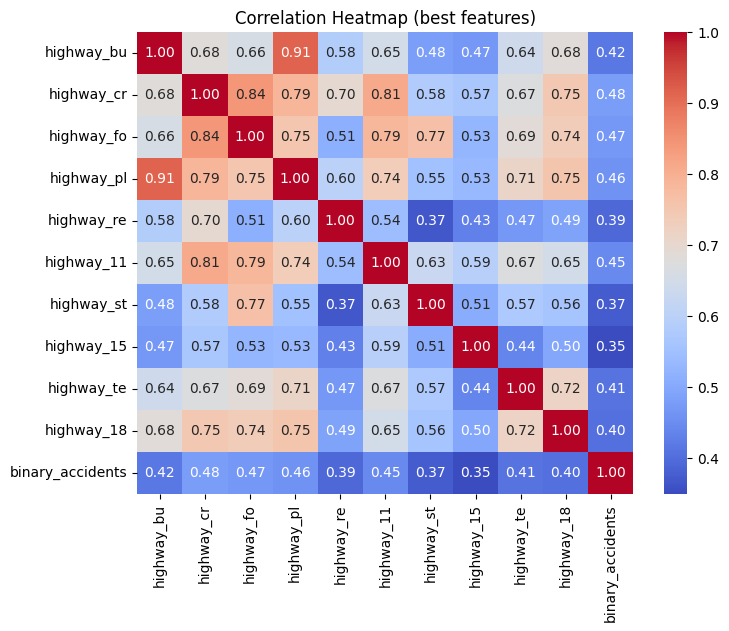

100%|██████████| 922/922 [00:21<00:00, 42.52it/s]


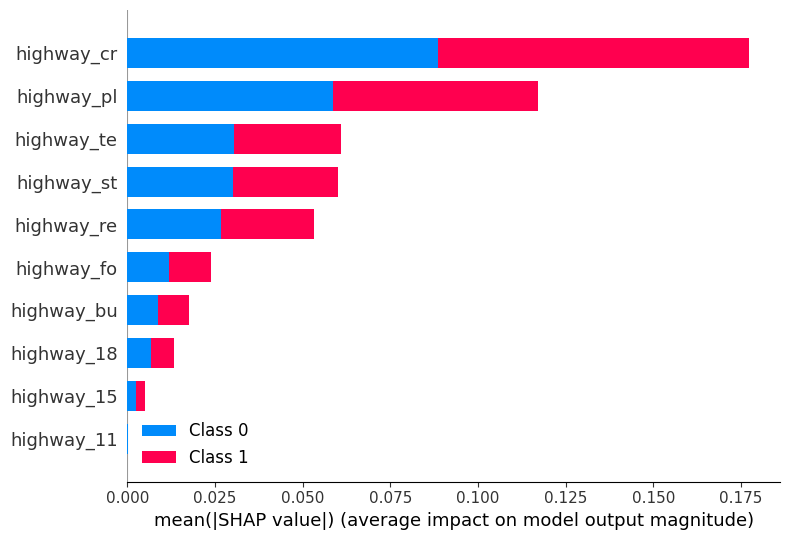

Analysis for Resolution = 9
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway_11,railway__9,railway_lo,highway__3,railway_wa,railway_13,railway_ya,highway_13,railway__1,highway__2,railway_tu,railway_co,highway_sp,highway__9,railway_ju,highway_pa,railway__4,railway__5,railway_ra,route_pist,railway__3,railway_de,highway__4,highway_br,railway_st,highway_12,railway_mi,railway_ha,railway_10,railway__2,highway_17,highway_co,railway_na,railway__7,highway_19,highway_mi,railway_12,highway__7,highway__1,railway_si,highway_el,highway_ra,railway_li,highway__5,railway_ab,highway_14,highway_mo,railway_pr,railway_bu,highway_16,railway__8,highway_tu,highway_10,railway_tr,railway_pl,railway_17,binary_accidents,railway_cr,highway_pr,railway_le,railway_di,highway__8,num_accidents,highway_pe,railway_15,highway_un,railway_16,railway_sw,highway_bu,highway_gi,highway_se,highway_18,railway_14,highway_pl,highway_li,highway_st,highway_cy,railway__6,highway_tr,highway_te,highway_re,highway__6,highway_15,highway_cr,highway_11,highway_fo
count,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000,19917.000000
mean,0.000351,0.000351,0.000351,0.000351,0.000351,0.000351,0.000603,0.000703,0.000703,0.000703,0.000703,0.001054,0.001406,0.001406,0.001657,0.002109,0.002109,0.002460,0.002460,0.002460,0.002460,0.002460,0.002460,0.003163,0.004870,0.005222,0.005473,0.005623,0.007431,0.008284,0.011548,0.011598,0.012301,0.012653,0.013355,0.016117,0.019280,0.022945,0.023899,0.025506,0.028117,0.029774,0.047798,0.048049,0.050108,0.050560,0.052518,0.063011,0.065723,0.068836,0.072400,0.077572,0.090676,0.091279,0.091982,0.110007,0.118241,0.123362,0.132851,0.135462,0.162976,0.178943,0.194055,0.261134,0.318421,0.355877,0.364111,0.374454,0.449164,0.451223,0.456545,0.484611,0.490988,0.556510,0.725611,0.860822,0.872270,1.055480,1.221770,1.517598,2.873776,2.874931,2.890144,3.488025,6.313451,14.950645
std,0.018744,0.018744,0.018744,0.018744,0.018744,0.018744,0.024539,0.026504,0.026504,0.037489,0.026504,0.041908,0.037469,0.037469,0.040672,0.052985,0.059248,0.085878,0.049541,0.131211,0.131211,0.081682,0.049541,0.085854,0.069619,0.081244,0.073777,0.079341,0.089883,0.105014,0.140892,0.193581,0.240504,0.604463,0.276847,0.125928,0.216858,0.306955,0.723762,0.274534,0.341471,0.401052,0.563523,0.686608,0.364083,0.326884,0.443259,0.466810,0.397255,0.477377,0.793868,0.322326,0.801129,0.529035,0.517396,0.508809,0.322901,0.978374,0.995886,1.160942,1.078906,0.852741,0.652716,1.698191,1.859476,1.755655,2.103487,2.485157,1.092015,1.669701,2.022439,1.640313,2.793287,1.227031,2.404361,2.806419,3.314407,4.415697,2.277092,3.747739,4.258721,4.893459,7.471125,6.841154,10.056678,27.657617
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

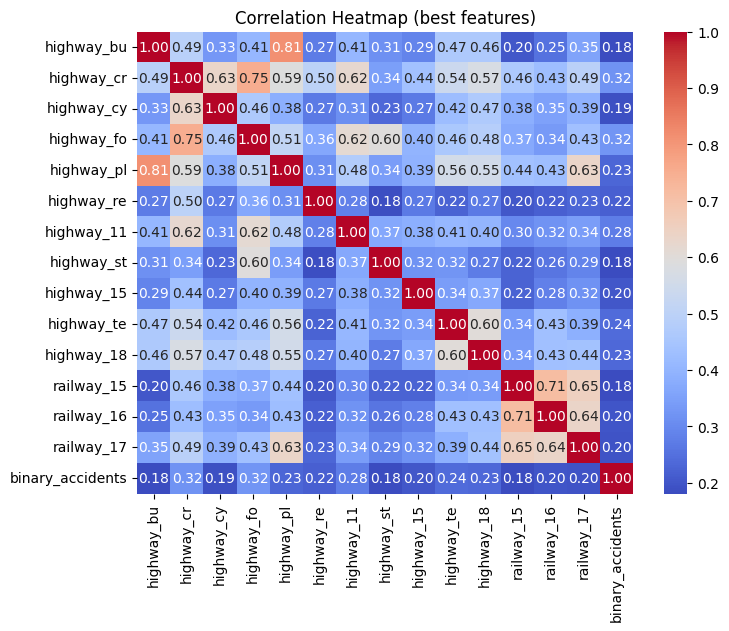

100%|██████████| 5976/5976 [17:03<00:00,  5.84it/s]


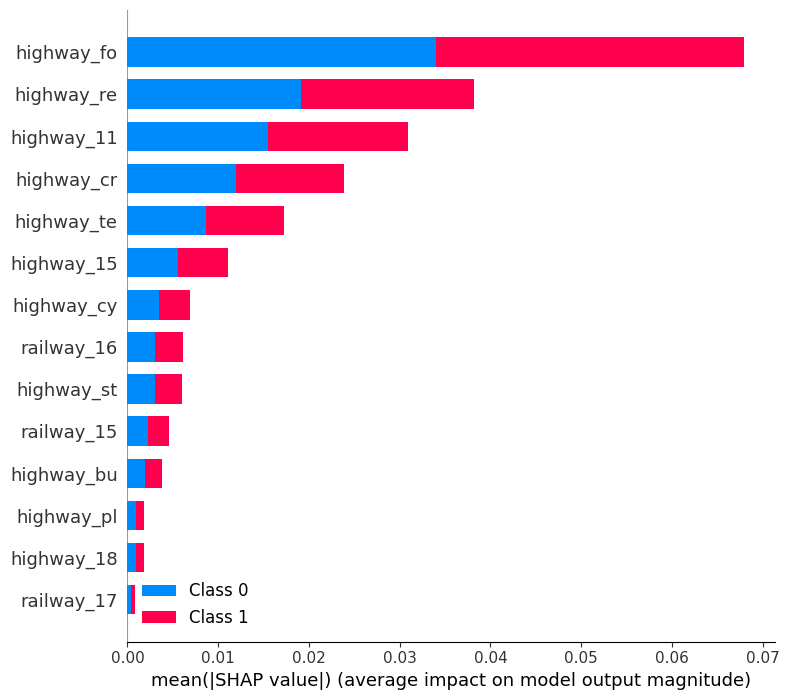

Analysis for Resolution = 10
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway__9,railway_lo,railway_wa,railway_11,railway_13,highway__3,railway_ya,railway__1,highway_13,railway_tu,highway__2,highway_sp,railway_co,railway_ju,railway_de,highway_pa,highway__9,highway__4,railway_ra,railway__3,railway__5,route_pist,railway_st,railway_mi,railway_ha,railway__4,highway_br,highway_12,railway_10,railway__2,highway_17,railway__7,highway_mi,highway_co,railway_12,railway_na,highway_19,railway_si,highway_el,highway__7,highway__1,highway_14,highway_ra,railway_bu,railway__8,highway__5,highway_tu,railway_li,highway_16,railway_ab,highway_mo,railway_17,railway_cr,highway_10,railway_pr,railway_le,railway_pl,binary_accidents,railway_tr,num_accidents,highway_pr,railway_di,railway_15,highway__8,railway_16,railway_sw,highway_pe,highway_bu,highway_gi,highway_18,highway_un,highway_pl,highway_se,railway_14,highway_st,highway_li,highway_cy,railway__6,highway_tr,highway_te,highway_15,highway_cr,highway__6,highway_re,highway_11,highway_fo
count,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000,136151.000000
mean,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000088,0.000103,0.000103,0.000103,0.000103,0.000206,0.000206,0.000242,0.000308,0.000308,0.000308,0.000353,0.000360,0.000360,0.000411,0.000720,0.000727,0.000823,0.000823,0.000874,0.000874,0.001014,0.001065,0.001219,0.001697,0.001851,0.002350,0.002725,0.002828,0.003033,0.003144,0.003738,0.004113,0.004480,0.005141,0.007404,0.008160,0.009666,0.010591,0.010922,0.011333,0.012391,0.012545,0.013581,0.015600,0.016092,0.018098,0.018266,0.019346,0.019941,0.020624,0.022872,0.024730,0.028373,0.029482,0.036731,0.046581,0.051421,0.053264,0.054888,0.062379,0.065897,0.066103,0.070936,0.073646,0.093881,0.100726,0.122364,0.130385,0.161108,0.170803,0.300453,0.321929,0.324309,0.423243,0.510727,0.651828,0.679334,1.254534,2.873111
std,0.007170,0.007170,0.007170,0.007170,0.007170,0.007170,0.009388,0.010140,0.010140,0.010140,0.010140,0.014339,0.017562,0.015567,0.022673,0.017561,0.017561,0.018773,0.018968,0.038612,0.030418,0.066491,0.026956,0.028670,0.030410,0.038604,0.034377,0.033397,0.032617,0.039067,0.045881,0.143395,0.048423,0.078172,0.086296,0.088058,0.104706,0.090662,0.104321,0.108786,0.222799,0.113001,0.164627,0.125876,0.294405,0.210464,0.112447,0.229453,0.175482,0.160697,0.200236,0.173274,0.282133,0.259856,0.221354,0.313051,0.210626,0.149495,0.208834,0.209566,0.335156,0.423470,0.503652,0.355338,0.630209,0.576685,0.509082,0.355522,0.450006,0.493802,0.550995,0.428665,0.680275,0.950302,0.732296,0.732705,1.033394,1.713407,0.846685,1.228840,1.588731,1.601400,1.511283,1.322133,2.601692,6.270634
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

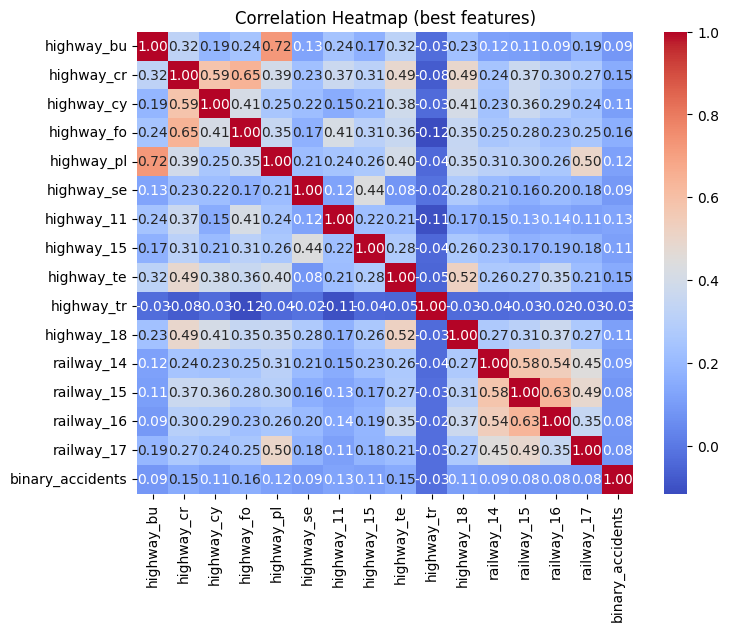

100%|██████████| 40846/40846 [1:47:01<00:00,  6.36it/s]  


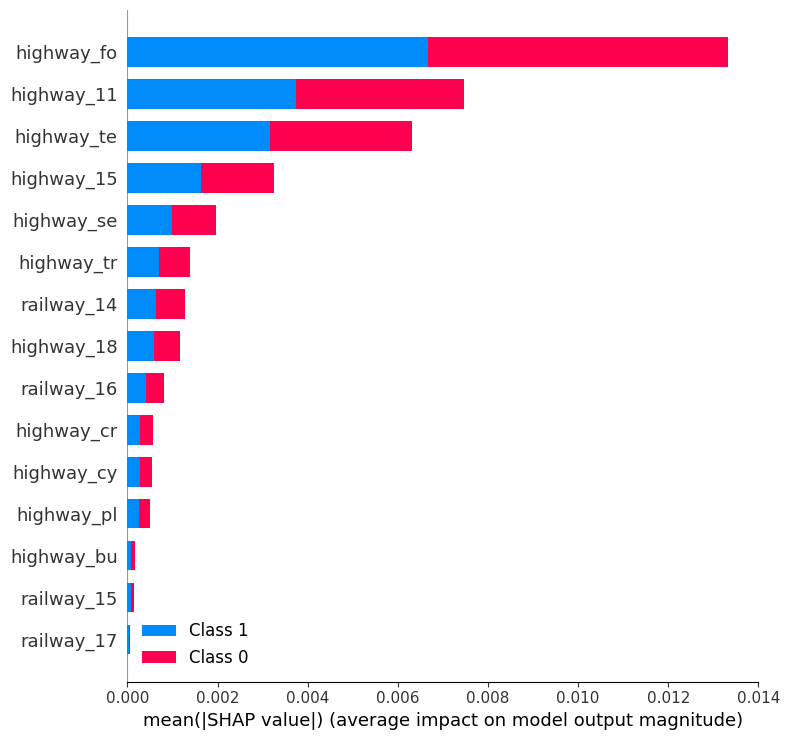

In [121]:
# Set resolutions
resolutions = [8, 9, 10]

# Initialize dataframe and dictionaries to store results
distribution_results = pd.DataFrame(columns=['Resolution', 'Num_Hexes', 'Accidents_Mean', 'Accidents_Std','Binary_Accidents_Mean', 'Binary_Accidents_Std'])
moran_i_results = pd.DataFrame(columns=['Resolution', 'Mean', 'Std', 'Min','Max'])
df_correlation_metrics = pd.DataFrame()

best_features_based_on_correlation = {}
local_moran_results = {} 

# Loop through resolutions
for resolution in resolutions:
    
    print(f"Analysis for Resolution = {resolution}")
    
    # Create hex dataframes
    hex_and_features_gdf = create_hex_gds(h3_resolution=resolution, city_name=city_name)
    accidents_gdf = get_accidents_gdf(h3_resolution=resolution, city_name=city_name, year=year)
    merged_gdf = merge_gdf(accidents_gdf, hex_and_features_gdf)
    
    # Convert accidents count to binary classification
    merged_gdf['binary_accidents'] = 0  # Initialize with 0
    merged_gdf.loc[merged_gdf["num_accidents"] > 0, "binary_accidents"] = 1.0

    new_row = {
        'Resolution': resolution,
        'Num_Hexes': len(merged_gdf),
        'Accidents_Mean': merged_gdf['num_accidents'].mean(),
        'Accidents_Std': merged_gdf['num_accidents'].std(),
        'Binary_Accidents_Mean': merged_gdf['binary_accidents'].mean(),
        'Binary_Accidents_Std': merged_gdf['binary_accidents'].std()
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)
    
    # Summary statistics of numerical columns
    summary_statistics = merged_gdf.describe()
    mean_row = summary_statistics.loc['mean']
    sorted_columns = mean_row.sort_values().index
    summary_statistics_sorted = summary_statistics[sorted_columns]
    print("Summary Statistics of Numerical Columns (Sorted by Mean):")
    display(summary_statistics_sorted)
    
    # Correlation
    best_features, correlation_metrics = correlation_analysis(merged_gdf)
    df_correlation_metrics = pd.concat([df_correlation_metrics, correlation_metrics], axis=1)
    best_features_based_on_correlation[resolution] = best_features
    
    shap_analysis(h3_resolution=resolution, merged_gdf=merged_gdf, selected_features=best_features)
    
    # Calculate Local Moran's I
    moran_i, p_sim, q = local_moran(merged_gdf, column='num_accidents')
    local_moran_results[resolution] = {'moran_i': moran_i, 'p_sim': p_sim, 'q': q}
    new_row = {
        'Resolution': resolution,
        'Mean':  np.mean(moran_i),
        'Std': np.std(moran_i),
        'Min': np.min(moran_i),
        'Max': np.min(moran_i),
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)

Średnia wartość Shapley'a (SHAP) maleje wraz ze wzrostem rozdzielczości. Dla resolution 10 jej wartość dla istotnych na podstawie wcześniejszej analizy korelacji cech, jest poniżej 0.015, cosugeruje, że cechy te mają niewielki wpływ na przewidywania modelu. 

Cechy, które mozna pominąć na podstawie statystyk (ich liczba jest odwrotnie proporcjonalna do wartości resolution, poniej została wypisana ich suma):
- railway__9
- railway_lo	
- railway_wa	
- railway_11	
- railway_13	
- highway__3	
- railway_ya	
- railway__1	
- highway_13	
- railway_tu	
- highway__2	
- highway_sp	
- railway_co	
- railway_ju	
- railway_de	
- highway_pa	
- highway__9	
- highway__4	
- railway_ra	
- railway__3	
- railway__5	
- route_pist	
- railway_st	
- railway_mi	
- railway_ha	
- railway__4	
- highway_br	
- highway_12	
- railway_10	
- railway__2	
- highway_17	
- railway__7	
- highway_mi						

Wszystkie z nich wystąpiły tylko raz w heksagonach dla rozdzielczości 8,9, 10. Ich srednia wartość występowania na hexagon jest bliska 0. Żadna z nich nie wykazuje wysokiej korelacji względem binarnej klasyfikacji wypadków.

In [122]:
df_correlation_metrics.columns = [f'resolution={resolution}' for resolution in resolutions]
print("Correlation Metrics of Binary Accidents with All Features:")
display(df_correlation_metrics)

Correlation Metrics of Binary Accidents with All Features:


,resolution=8,resolution=9,resolution=10
count,84.000000,84.000000,84.000000
mean,0.137728,0.066547,0.030421
std,0.141083,0.085236,0.042369
min,-0.057040,-0.034709,-0.027882
25%,0.024408,0.001429,-0.000996
50%,0.086363,0.029887,0.012360
75%,0.241005,0.113719,0.049865
max,0.478786,0.321900,0.161044


W analizie korelacji wypadków drogowych z różnymi cechami dla różnych rozdzielczości (8, 9, 10) można zauważyć, że średnie wartości korelacji maleją wraz ze wzrostem rozdzielczości. Wyniki wskazują na mniejszy wpływ lokalnych wzorców przestrzennych na występowanie wypadków drogowych w wyższych rozdzielczościach. Choć korelacja nie jest silna, to jej średnia wartość jest dodatnia, co sugeruje, że pewne cechy mogą korelować z występowaniem wypadków drogowych na lokalnym poziomie. Jednak największe wartości korelacji dla każdej rozdzielczości są stosunkowo umiarkowane, a więc lokalne wzorce nadal odgrywają pewną rolę w rozkładzie wypadków drogowych.

### Rozkład wypadków

In [15]:
print("Distribution of Accidents in Hexes:")
display(distribution_results)

Distribution of Accidents in Hexes:


,Resolution,Num_Hexes,Accidents_Mean,Accidents_Std,Binary_Accidents_Mean,Binary_Accidents_Std
0,8,3073,1.253824,2.359186,0.395054,0.488942
1,9,19917,0.194055,0.652716,0.118241,0.322901
2,10,136151,0.028373,0.209566,0.022872,0.149495


#### Wnioski
- Na niższych rozdzielczościach heksagony mają tendencję do grupowania większej liczby wypadków.
- Odchylenie standardowe liczby wypadków rośnie wraz ze wzrostem rozdzielczości. 
- Odchylenie standardowe na skali binarnej jest największe dla rozdzielczości 8 (0.49), co sugeruje większe zróżnicowanie między heksagonami pod względem obecności lub braku wypadków.


### Istotne cechy

In [14]:
print("Best Features Based on Correlation:\n")
for resolution, best_features in best_features_based_on_correlation.items():
    print(f"\nResolution {resolution}:")
    for feature in best_features:
        print(f"{feature}")

Best Features Based on Correlation:


Resolution 8:
highway_bu
highway_cr
highway_fo
highway_pl
highway_re
highway_11
highway_st
highway_15
highway_te
highway_18

Resolution 9:
highway_bu
highway_cr
highway_cy
highway_fo
highway_pl
highway_re
highway_11
highway_st
highway_15
highway_te
highway_18
railway_15
railway_16
railway_17

Resolution 10:
highway_bu
highway_cr
highway_cy
highway_fo
highway_pl
highway_se
highway_11
highway_15
highway_te
highway_tr
highway_18
railway_14
railway_15
railway_16
railway_17


In [12]:
features_resolution_8 = best_features_based_on_correlation[8]
features_resolution_9 = best_features_based_on_correlation[9]
features_resolution_10 = best_features_based_on_correlation[10]

# Find common features
common_features = set(features_resolution_8) & set(features_resolution_9) & set(features_resolution_10)

print("Common Features Across All Resolutions:")
for feature in common_features:
    print(feature)

Common Features Across All Resolutions:
highway_te
highway_18
highway_fo
highway_pl
highway_bu
highway_cr
highway_15
highway_11


### Moran's I

In [13]:
print("Local Moran's I Results:")
for resolution, results in local_moran_results.items():
    print(f"Resolution {resolution}: Moran's I = {results['moran_i']}, p_sim = {results['p_sim']}, q = {results['q']}")

Local Moran's I Results:
Resolution 8: Moran's I = [0.2824544  0.2824544  0.21737512 ... 0.21077618 0.18969434 0.04339257], p_sim = [0.001 0.001 0.001 ... 0.011 0.006 0.001], q = [3 3 3 ... 3 3 3]
Resolution 9: Moran's I = [0.0883899 0.0883899 0.0883899 ... 0.0883899 0.0883899 0.0883899], p_sim = [0.004 0.004 0.004 ... 0.001 0.001 0.001], q = [3 3 3 ... 3 3 3]
Resolution 10: Moran's I = [0.01833024 0.01833024 0.01833024 ... 0.01833024 0.01833024 0.01833024], p_sim = [0.001 0.001 0.001 ... 0.494 0.437 0.001], q = [3 3 3 ... 3 3 3]


In [88]:
res = {}
for resolution, results in local_moran_results.items():
    res[resolution] = []
    for key, value in results.items():
        res[resolution].extend([np.mean(value), np.std(value), np.min(value), np.max(value)])

local_moran_metrics = list(local_moran_results.values())[0].keys()
id_names = [f'{key}_{stat}' for key in local_moran_metrics for stat in ['mean', 'std', 'min', 'max']]
        
df = pd.DataFrame(res, index=id_names)
df.columns = [f'resolution={resolution}' for resolution in df.columns]
display(df)

,resolution=8,resolution=9,resolution=10
moran_i_mean,0.621093,0.288214,0.185247
moran_i_std,2.147266,1.764179,2.383969
moran_i_min,-0.604564,-1.572244,-1.112252
moran_i_max,29.148883,55.413463,224.021940
p_sim_mean,0.043701,0.070632,0.017132
p_sim_std,0.103758,0.127956,0.077877
p_sim_min,0.001000,0.001000,0.001000
p_sim_max,0.483000,0.493000,0.500000
q_mean,2.528148,2.651604,2.852965
q_std,0.857162,0.680807,0.413714


#### Wnioski

**moran_i** <br>
 Dla rozdzielczości 8 (największe hexy) mamy silniejszy lokalny wzorzec korelacji niż dla rozdzielczości 9 i 10. Wyższe wartości wskazują na obszary, gdzie wartości są podobne do swoich sąsiadów, tworząc lokalne skupiska. <br>
 Odchylenie jest największe dla rozdzielczości 10, więc istnieje duża zmienność korelacji przestrzennej między heksagonami.
 Dla rozdzielczości 10, gdzie mamy największe wartości maksymalne, istnieją obszary o bardzo silnej lokalnej korelacji przestrzennej, co może oznaczać klastry podobnych wartości.

**p-wartość** <br>
 Im niższa wartość, tym silniejszy jest dowód na lokalną przestrzenną korelację. Dla wszystkich rozdzielczości średnie wartości p-sim są stosunkowo niskie, co wskazuje na istotność statystyczną lokalnego wzorca przestrzennej korelacji. <br>
 Dla największych wartości p_sim (bliskich 0.5) może oznaczać, że lokalny wskaźnik Morana nie jest istotny statystycznie w tych obszarach. Wartości te mogą pochodzić z obszarów o losowym rozkładzie, gdzie brak jest wyraźnych lokalnych wzorców. Niemniej jednak, wartości minimalne i wartość średnia sugerują, że dla większości obszarów lokalne wzorce korelacji są istotne.

**Q** <br>
 Wartości Q określają, do której kategorii kwadrantu należy dany obszar w analizie lokalnego Moran'a I. Średnie wartości dla wszystkich rozdzielczości wskazują na to, że większość obszarów należy do kwadrantów 1, 2 lub 3, co oznacza, że istnieją klastry obszarów o podobnych wartościach w sąsiedztwie.  <br>
 Kwadrant 4 oznacza obszary o wysokich wartościach otoczone przez obszary o niskich wartościach. Dla rozdzielczości 8 i 9 maksymalna wartość Q wynosi 4, co oznacza, że niektóre obszary są otoczone przez obszary o podobnych wartościach. Dla rozdzielczości 10 maksymalna wartość Q wynosi 3, co znaczy, że obszary o wyższych wartościach są bardziej izolowane lub mają bardziej zróżnicowane sąsiedztwo.